In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## CRAG: Corrective RAG

Corrective RAG 전략을 사용하여 RAG 기반 시스템을 개선하는 방법입니다.  
  
CRAG는 검색된 문서들에 대한 자기 반성(self-reflection) 및 자기 평가(self-evaluation) 단계를 포함하여, 검색-생성 파이프라인을 정교하게 다루는 접근법입니다.

##### 그래프 흐름

![crag](./assets/langgraph_use_case_crag.png)

#### CRAG 란?

[LangGraph CRAG 튜토리얼 (공식 문서)](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)

Corrective-RAG (CRAG) 는 RAG(Retrieval Augmented Generation) 전략에서 **검색 과정에서 찾아온 문서를 평가하고, 지식을 정제(refine) 하는 단계를 추가한 방법론**입니다. 생성에 앞서 검색 결과를 점검하고 필요하다면 보조적인 검색을 수행하며, 최종적으로 품질 높은 답변을 생성하기 위한 일련의 프로세스를 포함합니다.  
  
##### CRAG의 핵심 아이디어

[논문(Corrective Retrieval Augmented Generation) 링크](https://arxiv.org/pdf/2401.15884)

1. 검색된 문서 중 하나 이상이 사전 정의된 관련성 임계값(retrieval validation score) 을 초과하면 생성 단계로 진행합니다.
2. 생성 전에 지식 정제 단계를 수행합니다.
3. 문서를 "knowledge strips" 로 세분화합니다. (여기서, 문서 검색 결과수, k 를 의미합니다.)
4. 각 지식 스트립을 평가하고 관련성 여부를 score 로 평가합니다. (여기서는 문서 chunk 단위로 평가합니다.)
5. 모든 문서가 관련성 임계값 이하이거나 평가 결과 신뢰도가 낮을 경우, 추가 데이터 소스(예: 웹 검색)로 보강합니다.
6. 웹 검색을 통한 보강 시, 쿼리 재작성(Query-Rewrite) 을 통해 검색 결과를 최적화합니다.

##### 이번 실습 주요 내용
  
이 튜토리얼에서는 LangGraph를 활용하여 CRAG 접근법의 일부 아이디어를 구현합니다.  
여기서는 지식 정제 단계는 생략하고, 필요하다면 노드로 추가할 수 있는 형태로 설계합니다.
또한, 관련 있는 문서가 하나도 없으면 웹 검색을 활용하여 검색을 보완할 것입니다.
웹 검색에는 Tavily Search를 사용하고, 검색 최적화를 위해 질문 재작성(Question Re-writing) 을 도입합니다.
  

##### 주요 단계 개요

- Retrieval Grader: 검색된 문서의 관련성을 평가
- Generate: LLM을 통한 답변 생성
- Question Re-writer: 질문 재작성을 통한 검색 질의 최적화
- Web Search Tool: Tavily Search를 통한 웹 검색 활용
- Create Graph: LangGraph를 통한 CRAG 전략 그래프 생성
- Use the graph: 생성된 그래프를 활용하는 방법

### 기능 구현

#### PDF 기반 Retrieval Chain 생성

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

#### 검색 문서의 관련성 평가 (Question-Retrieval Evaluation)

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from models import get_model_name, LLMs
from pydantic import BaseModel, Field

# 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 구조화된 출력을 생성하는 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Retrieval 평가기 초기화
retrieval_grader = grade_prompt | structured_llm_grader

`retrieval_grader`를 사용하여 질문이 이 문서와 관련이 있는지 없는지를 평가합니다.  
한 개의 문서에 대한 평가를 수행합니다.  
결과는 단일 무서에 대한 관련성 여부가 yes or no 로 반환됩니다.

In [7]:
# 질문 정의
question = "AI 위험 유형에 대해 설명하세요."

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 1번 index 문서의 페이지 내용을 추출
doc_txt = docs[1].page_content

# 검색된 문서와 질문을 사용하여 관련성 평가를 실행하고 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


#### 답변 생성 체인

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# LangChain Hub에서 RAG 프롬프트를 가져와 사용
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

AI 위험 유형은 다음과 같이 분류됩니다:

1. **가짜 콘텐츠를 통한 개인 위해**: 사기, 피싱, 합성, 복제 등.
2. **허위 정보 생성**: 광고, 마이크로 타게팅 등.
3. **사용자 설득 및 여론 조작**: 대화형 AI를 통한 악의적 사용.
4. **사이버 공격 및 보안**: 시스템의 기밀성, 무결성, 사용 가능성에 대한 위협.

이 외에도 AI의 오작동 위험, 교차 위험 등이 있으며, 다양한 연구에서 AI 위험 요인들이 정의되고 분석되고 있습니다.

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 15)


#### 쿼리 재작성(Question Re-writer)

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 설정
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewrite 시스템 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized 
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 프롬프트 정의
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Question Re-writer 체인 초기화
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [10]:
# 실행 및 결과 확인
print(f'[원본 질문]: "{question}"')
print("[쿼리 재작성]:", question_rewriter.invoke({"question": question}))

[원본 질문]: "AI 위험 유형에 대해 설명하세요."
[쿼리 재작성]: AI의 다양한 위험 유형에 대해 자세히 설명해 주실 수 있나요?


#### 웹 겸색 도구

In [11]:
# 웹 검색 도구 초기화
from tools_tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
web_search_tool = TavilySearch(max_results=3)

In [12]:
# 웹 검색 도구 실행
results = web_search_tool.invoke({"query": question})
print(results)

[{'title': 'Ai 위험 유형과 사례 분석으로 안전 확보해야 < 보안 < Ai·보안·Sw < 기사본문 - 테크월드뉴스 - 한평훈 기자', 'url': 'https://www.epnc.co.kr/news/articleView.html?idxno=308497', 'content': 'ai의 주요 위험 유형은 크게 악의적 사용 위험, 오작동 위험, 시스템적 위험, 교차 위험 요인으로 나눌 수 있다. 악의적 사용 위험은 ai가 범죄나 불법적 목적으로 악용될 가능성을 의미한다. ai를 활용한 피싱 공격이나 가짜 뉴스 생성, 딥페이크 등의 문제는 이미', 'score': 0.8755427, 'raw_content': None}, {'title': 'AI 위험 유형 및 사례 분석 (A Comprehensive Review on AI Risks and Cases)', 'url': 'https://www.ifs.or.kr/bbs/board.php?bo_table=research&wr_id=10946', 'content': 'ai 위험 요인은 기술적 논의를 넘어선 사회적,제도적 요인을 포함 - 최근 연구를 살펴본 결과, ai의 위험 요인은 단순히 기술적 결함을 넘어서 사용자에 의한 악용, 국가별·지역별 격차로 인한 사회적 위험 요인까지 확대되고 있음을 확인', 'score': 0.7959917, 'raw_content': 'AI 위험 유형 및 사례 분석(A Comprehensive Review on AI Risks and Cases) > 보고서\n본문 바로가기\n 사이트맵\n 검색\n홈페이지 메뉴\nHOME\n(current)\n뉴스인사이트\n(current)\n정책연구\n(current)\n김광두의 1년 후\n(current)\n여론광장\n(current)\nIFS소개\n(current)\n보고서\n보고서\nINDEX\n기획시리즈\n전체 카테고리 보기\n국가미래연구원에서는 연구진의 논문 및 자료와 함께 연구원 주최 세미나의 주제발표 및 토론내용 등을 PDF 파일로 서비

### 그래프 정의

#### 1. 상태 정의

In [13]:
from typing import Annotated, List
from typing_extensions import TypedDict


# 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

#### 2. 노드 정의

In [15]:
from langchain.schema import Document


# 문서 검색 노드
def retrieve(state: GraphState):
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state: GraphState):
    question = state["question"]
    documents = state["documents"]

    # RAG를 사용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 평가 노드
def grade_documents(state: GraphState):
    question = state["question"]
    documents = state["documents"]

    # 필터링된 문서
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Question-Document 의 관련성 평가
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            continue

    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}


# 쿼리 재작성 노드
def query_rewrite(state: GraphState):
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state: GraphState):
    question = state["question"]
    documents = state["documents"]

    # 웹 검색 수행
    docs = web_search_tool.invoke({"query": question})
    # 검색 결과를 문서 형식으로 변환
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}

# 조건부 엣지에 활용
def decide_to_generate(state: GraphState):
    # 평가된 문서를 기반으로 다음 단계 결정
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    # 웹 검색 필요 여부
    web_search = state["web_search"]

    if web_search == "Yes":
        # 웹 검색으로 정보 보강이 필요한 경우
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        # 쿼리 재작성 노드로 라우팅
        return "query_rewrite"
    else:
        # 관련 문서가 존재하므로 답변 생성 단계(generate) 로 진행
        print("==== [DECISION: GENERATE] ====")
        return "generate"

#### 3. 엣지 설정 및 그래프 컴파일

In [16]:
from langgraph.graph import END, StateGraph, START

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

# 엣지 연결
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

#### 4. 그래프 시각화

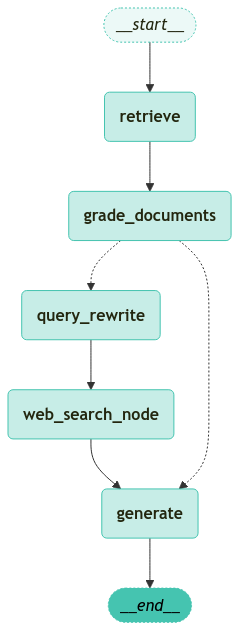

In [17]:
from graphs import visualize_graph

visualize_graph(app)

#### 5. 그래프 실행

In [19]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 스트리밍 형식으로 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?
🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'(Samsung Gauss)입니다.

**Source**
- Document (page content)

In [20]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "2024년 노벨문학상 수상자의 이름은?",
}

In [21]:
# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='∙ 유재흥, 노재원, 장진철, 조지연 (2024.07), 해외 AI안전연구소 추진 현황과 시사점, SPRi 이슈리포트
∙ 한미정 (2024. 03), 삼성 SDS 인사이트 리포트: AI 리스크에 대한 글로벌 대응 동향 및 시사점
∙ 이은경, 이동현, 조원영 (2024.06), SW로 탄소중립을 지원하는 기후 기술·기업 사례 연구, SPRi 이슈리포트
25' metadata={'source': './data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'file_path': './data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'page': 29, 'total_pages': 32, 'Author': 'user', 'Creator': 'Hwp 2018 10.0.0.14241', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241106094709+09'00'", 'ModDate': "D:20241106094709+09'00'", 'PDFVersion': '1.4'}
page_content='국내문헌
∙ 외교부 (2024.05), AI 서울 정상회의 서울 선언 및 의향서
∙ 한국정보통신기술협회(TTA) (2023.12), 인공지능 시스템 신뢰성 제고를 위한 요구사항
∙ 김태순 (2024.05), The AI Report: 美 NIST AI 위험관리 프레임워크(AI RMF) 1.0 분석 및 시사점, NIA
∙ 장진철, 노재원, 유재흥, 조지연 (2024.08), 책임 있는 AI를 위한 기업의 노력과 시사점, SPRi 이슈리포트' metadata={'source': './data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'file_path': './data/IS-183_AI 위험 유형 및 사례 분석(최종).p

In [22]:
# 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "generate"],
)


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 누구인가요?
🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한국 작가 한강입니다.

**Source**
- Document (page 1)